In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('ggplot') # emulate pretty r-style plots



import gc


%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Features selection & interaction

In [2]:
data1 = pd.read_csv('processed_data.csv')
macro_data =  pd.read_csv('8macro.csv')

### 1 features selection 

筛选与因变量相关系数绝对值最大的n个自变量

In [3]:
corr_matrix = data1.corr()
corr_matrix = abs(corr_matrix)

abs(相关系数)从高到低

In [4]:
corr_matrix["RET"].sort_values(ascending = False)

RET         1.000000
sp          0.025280
rd_mve      0.023341
baspread    0.023078
agr         0.020517
              ...   
70.0        0.000085
72.0        0.000058
26.0        0.000023
9.0         0.000015
53.0        0.000002
Name: RET, Length: 171, dtype: float64

In [5]:
## 去掉因变量本身、股票代码、日期之后，选相关系数绝对值排前n的变量 (n = 30)
n = 30 #保留变量个数
features_selected = corr_matrix["RET"].sort_values(ascending = False).index.drop(['RET','permno', 'DATE'])[0:n]
features_selected

Index(['sp', 'rd_mve', 'baspread', 'agr', 'ill', 'idiovol', 'dolvol', 'lev',
       'mom36m', 'invest', 'orgcap', 'egr', 'retvol', 'ps', 'hire', 'lgr',
       'chcsho', 'ep', 'rd', 'tang', 'sgr', 'grltnoa', 'gma', 'chinv', 'mom1m',
       'nincr', 'chmom', 'cashpr', 'acc', 'absacc'],
      dtype='object')

In [6]:
data2 = data1[["DATE","RET","permno"]]
data2 = data2.join(data1[features_selected])
data2.head()

,DATE,RET,permno,sp,rd_mve,baspread,agr,ill,idiovol,dolvol,...,sgr,grltnoa,gma,chinv,mom1m,nincr,chmom,cashpr,acc,absacc
0,19570329,0.018405,10006,0.0,0.0,0.013856,0.0,1.557681e-07,0.024863,10.296745,...,0.0,0.0,0.0,0.0,0.002016,0.0,0.134574,0.0,0.0,0.0
1,19570329,0.000000,10014,0.0,0.0,0.031389,0.0,8.383815e-06,0.065248,7.032404,...,0.0,0.0,0.0,0.0,-0.086957,0.0,0.006667,0.0,0.0,0.0
2,19570329,-0.003846,10022,0.0,0.0,0.010066,0.0,5.360386e-06,0.029338,7.294038,...,0.0,0.0,0.0,0.0,-0.037037,0.0,0.058761,0.0,0.0,0.0
3,19570329,0.077907,10030,0.0,0.0,0.009523,0.0,1.090908e-07,0.022007,9.516942,...,0.0,0.0,0.0,0.0,0.000000,0.0,-0.032065,0.0,0.0,0.0
4,19570329,-0.017730,10057,0.0,0.0,0.007661,0.0,2.386914e-07,0.025453,8.421013,...,0.0,0.0,0.0,0.0,-0.030717,0.0,-0.102811,0.0,0.0,0.0


### 2 interaction

循环，生成股票特征*macro的变量们，一共n*8个

In [7]:
data3 = data3.reset_index(drop = True) 
datay = data3[['RET','permno']]              
data3 = data3.drop(['RET','permno'], axis =1) ## 因变量等的不参与interaction

In [8]:
from tqdm import tqdm
data_tmp = data3[["DATE"]]

# 第一层：遍历data2的每一列
for i in tqdm(range(1,len(data3.columns))):
    
    # 第二层：遍历macrodata的每一列
    for j in tqdm(range(1,len(macro_data.columns))):
        
        colnames = data3.columns[i] + "*" + macro_data.columns[j]
        col_tmp = pd.DataFrame(columns = {colnames})

        # 第三层：遍历指定data2列的每一行
        for k in range(len(data3)):
            
            DATE = int(data3.iloc[k,0]/100)
            #print(DATE) #取data2日期
            macroMask = macro_data[macro_data['yyyymm'] == DATE].index 
            #print(macroMask)#取以上日期对应的macrodata
            macro_tmp = macro_data.loc[macroMask]
            #print(macro_tmp)
            
            if len(macro_tmp) == 0:
                new_blank = None
            else:
                new_blank = macro_tmp.iloc[0,j]*data3.iloc[k,i]
               # print(new_blank)
            blank_tmp = pd.DataFrame([new_blank])
            blank_tmp.columns = [colnames]
            col_tmp = col_tmp.append(blank_tmp,ignore_index=True)
        
        data_tmp = data_tmp.join(col_tmp[[colnames]])

100%|██████████| 30/30 [22:12<00:00, 44.41s/it]


In [9]:
## interation变量
data_tmp.head()

,DATE,sp*dp,sp*ep,sp*b/m,sp*ntis,sp*tbl,sp*svar,sp*tms,sp*dfy,rd_mve*dp,...,acc*tms,acc*dfy,absacc*dp,absacc*ep,absacc*b/m,absacc*ntis,absacc*tbl,absacc*svar,absacc*tms,absacc*dfy
0,20130731,-4.475882,-3.324472,0.372292,0.009560,0.000457,0.000574,0.038880,0.011207,-0.000000,...,-0.000256,-0.000074,-0.029527,-0.021931,0.002456,0.000063,0.000003,0.000004,0.000256,0.000074
1,20011130,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,...,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,20040630,-0.470940,-0.344545,0.031993,0.001658,0.001453,0.000088,0.004634,0.000881,-0.096834,...,-0.003751,-0.000713,-0.381191,-0.278884,0.025896,0.001342,0.001176,0.000071,0.003751,0.000713
3,19630430,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,...,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,20140331,-1.342496,-0.994100,0.119312,0.005586,0.000170,0.000296,0.011298,0.002314,-0.227667,...,0.001063,0.000218,-0.126338,-0.093552,0.011228,0.000526,0.000016,0.000028,0.001063,0.000218


In [10]:
data3 = data3.join(data_tmp.drop(['DATE'], axis=1)) ## 把interaction变量和原有的30个特征放一起
data3 = data3.join(datay[['RET','permno']])        ## 再把因变量啥的join回来

In [11]:
data3.to_csv('data3.csv', index = False)

这里的data3就是下面跑模型用到的data1了

# ----------------------------------------------------------------------------------------------------------------

## PCR

In [12]:
def GetRSqr(testY,pred):
    
    upperSum=0
    lowerSum=0
    for i in range(len(testY)):
        upperSum+=(testY[i]-pred[i])**2
        lowerSum+=(testY[i])**2
        
    return 1-(upperSum/lowerSum)

In [64]:
#存储每一个batch的r
#warnings.filterwarnings('ignore')

#存储每一个batch的r
rList=[]
combineList = []

for i in range(30):
    
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    
    trainingMask = (data3['DATE'] >= trainingMaskStart) & (data3['DATE'] < trainingMaskEnd)
    trainingData = data3.loc[trainingMask]
    
    validationMask = (data3['DATE'] >= trainingMaskEnd) & (data3['DATE'] < validationMaskEnd)
    validationData = data3.loc[validationMask]
    
    testMask = (data3['DATE'] >= validationMaskEnd) & (data3['DATE'] < testMaskEnd)
    testData = data3.loc[testMask]
    
    
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
    
    #函数：调用rf来对trainingData训练并fit validationData，
    #rf调节的地方是max_depth=3,5; max_features=3,5; 这样就有4个组合要调了
    #然后我们用验证集判断R2，结果最好的那一组参数将被传入 testData 
    #testData再调用一个函数来计算R2，并存入全局变量rList中
    
    bestRSqr = float("-inf")
    bestregr = None
    bestCombine = None
    
    for K in [20,30,40,50,60,70]:
 #   for feature in [5,10]:
            #rf = RandomForestRegressor(n_estimators=300, random_state=72, max_depth=depth, max_features=feature)
            #rf.fit(trainingData_x,trainingData_y)
            
            #pred = rf.predict(validationData_x)
            #currentRSqr = GetRSqr(validationData_y.values, pred)
            
        
            # Train regression model on training data 
        pca=PCA(n_components=K)
 
        regr = LinearRegression()
        regr.fit(pca.fit_transform(scale(trainingData_x)), trainingData_y)
        
        pred = regr.predict(pca.fit_transform(scale(validationData_x)))
        currentRSqr = GetRSqr(validationData_y.values, pred)
        
        
        if(currentRSqr>bestRSqr):
            bestRSqr=currentRSqr
            bestregr=regr
            bestCombine=K
    
    pca2=PCA(n_components=bestCombine)
    resultPred = bestregr.predict(pca2.fit_transform(scale(testData_x)))
    resultRSqr = GetRSqr(testData_y.values, resultPred)
    print('result R square for batch',i,': ', resultRSqr, 'best combine:', bestCombine)
    rList.append(resultRSqr)
    combineList.append(bestCombine)

result R square for batch 0 :  -0.04626210674415865 best combine: 20
result R square for batch 1 :  -0.17705216183972872 best combine: 20
result R square for batch 2 :  -0.0716554467474162 best combine: 20
result R square for batch 3 :  -0.25372533264690933 best combine: 20
result R square for batch 4 :  -0.14795610323079167 best combine: 20
result R square for batch 5 :  -0.24262834495966534 best combine: 20
result R square for batch 6 :  -0.13995412408654784 best combine: 20
result R square for batch 7 :  -0.2215074790379119 best combine: 20
result R square for batch 8 :  -0.04438992919103746 best combine: 20
result R square for batch 9 :  0.03686639496830002 best combine: 20
result R square for batch 10 :  -0.01117138193389966 best combine: 20
result R square for batch 11 :  -0.02610524592763963 best combine: 20
result R square for batch 12 :  -0.025217380289779934 best combine: 20
result R square for batch 13 :  -0.01950619185734581 best combine: 20
result R square for batch 14 :  

In [88]:
pcr_rList = rList               ##储存R²结果
pcr_combineList = combineList   ##储存参数组合
#得到30batch最终的平均r2：
print('the R squaure is: ',sum(pcr_rList) / len(pcr_rList))

the R squaure is:  -0.058930690413134326


In [67]:
var = data3.drop(['RET','permno', 'DATE'],axis = 1).columns ## data3即为跑模型用到的数据
R2_loss = pd.DataFrame(columns = {"var","r2_loss"})         ## 储存每个变量的R² loss

for j in var:    
    data_drop_1_var = data3.drop(j,axis = 1,inplace = False)
    
    i = 29
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    trainingMask = (data_drop_1_var['DATE'] >= trainingMaskStart) & (data_drop_1_var['DATE'] < trainingMaskEnd)
    trainingData = data_drop_1_var.loc[trainingMask]
    validationMask = (data_drop_1_var['DATE'] >= trainingMaskEnd) & (data_drop_1_var['DATE'] < validationMaskEnd)
    validationData = data_drop_1_var.loc[validationMask]
    testMask = (data_drop_1_var['DATE'] >= validationMaskEnd) & (data_drop_1_var['DATE'] < testMaskEnd)
    testData = data_drop_1_var.loc[testMask]
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
        
    ## ----------------------  这里要根据模型不同、参数不同修改一下  --------------------##
    # 这是之前调好的hyper parameters
    K = pcr_combineList[i]         ## 取之前存储的bestCombine         

    
    pca=PCA(n_components=K)
    regr = LinearRegression()
    regr.fit(pca.fit_transform(scale(trainingData_x)), trainingData_y)
    resultPred= regr.predict(pca.fit_transform(scale(testData_x)))
    ## -----------------------------------------------------------------------------------##

    resultRSqr = GetRSqr(testData_y.values, resultPred)
    RSqr_loss = pcr_rList[i] - resultRSqr    ## 计算R²减少的量，越大说明变量越重要
    blank_tmp = pd.DataFrame({'var': j, 'r2_loss': RSqr_loss},index = (0,))
    R2_loss = R2_loss.append(blank_tmp,ignore_index=True)

In [68]:
#得到30batch最终的平均r2：
print('the R squaure is: ',sum(pcr_rList) / len(pcr_rList))

the R squaure is:  -0.058930690413134326


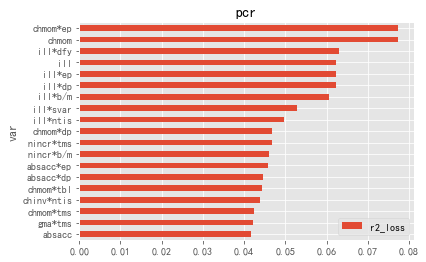

In [69]:
Rplot = R2_loss.sort_values(by="r2_loss",axis=0,ascending=False).iloc[0:19,]  ##只取最重要的20个特征画图
Rplot.sort_values(by="r2_loss",axis=0,ascending=True).plot(x = "var", y = "r2_loss",kind='barh',title="pcr")

# PCR

In [83]:
#存储每一个batch的r
#warnings.filterwarnings('ignore')

#存储每一个batch的r
rList2=[]
combineList2 = []

for i in range(30):
    
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    
    trainingMask = (data3['DATE'] >= trainingMaskStart) & (data3['DATE'] < trainingMaskEnd)
    trainingData = data3.loc[trainingMask]
    
    validationMask = (data3['DATE'] >= trainingMaskEnd) & (data3['DATE'] < validationMaskEnd)
    validationData = data3.loc[validationMask]
    
    testMask = (data3['DATE'] >= validationMaskEnd) & (data3['DATE'] < testMaskEnd)
    testData = data3.loc[testMask]
    
    
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
    
    #函数：调用rf来对trainingData训练并fit validationData，
    #rf调节的地方是max_depth=3,5; max_features=3,5; 这样就有4个组合要调了
    #然后我们用验证集判断R2，结果最好的那一组参数将被传入 testData 
    #testData再调用一个函数来计算R2，并存入全局变量rList中
    
    bestRSqr = float("-inf")
    bestpls = None
    bestCombine = None
    
    for K in range(10,30):
        
 #   for feature in [5,10]:
            #rf = RandomForestRegressor(n_estimators=300, random_state=72, max_depth=depth, max_features=feature)
            #rf.fit(trainingData_x,trainingData_y)
            
            #pred = rf.predict(validationData_x)
            #currentRSqr = GetRSqr(validationData_y.values, pred)
            

            # Train regression model on training data 
        pls = PLSRegression(n_components=K)
 
        
        pls.fit(scale(trainingData_x), trainingData_y)
        
        pred = pls.predict(scale(validationData_x))
        currentRSqr = GetRSqr(validationData_y.values, pred)
            
        if(currentRSqr>bestRSqr):
            bestRSqr=currentRSqr
            bestpls=pls
            bestCombine=K
            #print(bestCombine)
            #print(bestRSqr)
    
    resultPred = bestpls.predict((scale(testData_x)))
    resultRSqr = GetRSqr(testData_y.values, resultPred)
    print('result R square for batch',i,': ', resultRSqr, 'best combine:', bestCombine)
    rList2.append(resultRSqr)
    combineList2.append(bestCombine)

result R square for batch 0 :  [0.00979125] best combine: 10
result R square for batch 1 :  [-1.56345062] best combine: 10
result R square for batch 2 :  [-1.28203894] best combine: 10
result R square for batch 3 :  [-0.77193439] best combine: 10
result R square for batch 4 :  [-0.10055553] best combine: 10
result R square for batch 5 :  [-0.17944462] best combine: 10
result R square for batch 6 :  [-0.1688492] best combine: 10
result R square for batch 7 :  [-0.1012075] best combine: 10
result R square for batch 8 :  [-0.10382077] best combine: 10
result R square for batch 9 :  [-0.12333] best combine: 10
result R square for batch 10 :  [-0.00557549] best combine: 10
result R square for batch 11 :  [-0.05681856] best combine: 10
result R square for batch 12 :  [-0.17815324] best combine: 10
result R square for batch 13 :  [-0.08738865] best combine: 10
result R square for batch 14 :  [-0.03988827] best combine: 10
result R square for batch 15 :  [-0.15340148] best combine: 10
result R

In [87]:
pls_rList = rList2               ##储存R²结果
pls_combineList = combineList2   ##储存参数组合
#得到30batch最终的平均r2：
print('the R squaure is: ',sum(pls_rList) / len(pls_rList))

the R squaure is:  [-0.27416092]


In [89]:
var = data3.drop(['RET','permno', 'DATE'],axis = 1).columns ## data3即为跑模型用到的数据
R2_loss = pd.DataFrame(columns = {"var","r2_loss"})         ## 储存每个变量的R² loss

for j in var:    
    data_drop_1_var = data3.drop(j,axis = 1,inplace = False)
    
    i = 29
    trainingMaskStart = 19570301
    trainingMaskEnd = 19750000+i*10000
    validationMaskEnd = trainingMaskEnd+120000
    testMaskEnd = validationMaskEnd+10000
    trainingMask = (data_drop_1_var['DATE'] >= trainingMaskStart) & (data_drop_1_var['DATE'] < trainingMaskEnd)
    trainingData = data_drop_1_var.loc[trainingMask]
    validationMask = (data_drop_1_var['DATE'] >= trainingMaskEnd) & (data_drop_1_var['DATE'] < validationMaskEnd)
    validationData = data_drop_1_var.loc[validationMask]
    testMask = (data_drop_1_var['DATE'] >= validationMaskEnd) & (data_drop_1_var['DATE'] < testMaskEnd)
    testData = data_drop_1_var.loc[testMask]
    trainingData_y = trainingData['RET']
    trainingData_x = trainingData.drop(['RET','permno', 'DATE'], axis=1)
    validationData_y = validationData['RET']
    validationData_x = validationData.drop(['RET','permno', 'DATE'], axis=1)
    testData_y = testData['RET']
    testData_x = testData.drop(['RET','permno', 'DATE'], axis =1)
        
    ## ----------------------  这里要根据模型不同、参数不同修改一下  --------------------##
    # 这是之前调好的hyper parameters
    K = pls_combineList[i]         ## 取之前存储的bestCombine
                 
    pls = PLSRegression(n_components=K)
    pls.fit(scale(trainingData_x), trainingData_y)       
    resultPred = pls.predict(scale(testData_x))
    
    ## -----------------------------------------------------------------------------------##

    resultRSqr = GetRSqr(testData_y.values, resultPred)
    RSqr_loss = pls_rList[i] - resultRSqr    ## 计算R²减少的量，越大说明变量越重要
    blank_tmp = pd.DataFrame({'var': j, 'r2_loss': RSqr_loss},index = (0,))
    R2_loss = R2_loss.append(blank_tmp,ignore_index=True)

In [90]:
#得到30batch最终的平均r2：
print('the R squaure is: ',sum(pls_rList) / len(pls_rList))

the R squaure is:  [-0.27416092]


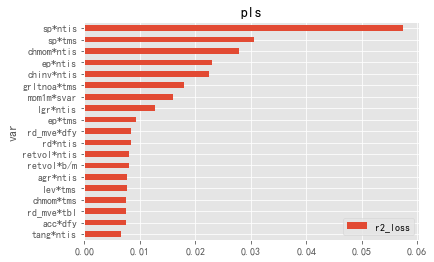

In [91]:
Rplot = R2_loss.sort_values(by="r2_loss",axis=0,ascending=False).iloc[0:19,]  ##只取最重要的20个特征画图
Rplot.sort_values(by="r2_loss",axis=0,ascending=True).plot(x = "var", y = "r2_loss",kind='barh',title="pls")